### Import Libraries 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn import metrics
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
df = pd.read_csv("listings.csv")
df.shape

/var/folders/96/rqbzsn5529g1d_vxq41j85lr0000gn/T/ipykernel_39563/2260444368.py:1: DtypeWarning: Columns (58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("listings.csv")


(32877, 74)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32877 entries, 0 to 32876
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            32877 non-null  int64  
 1   listing_url                                   32877 non-null  object 
 2   scrape_id                                     32877 non-null  int64  
 3   last_scraped                                  32877 non-null  object 
 4   name                                          32875 non-null  object 
 5   description                                   31769 non-null  object 
 6   neighborhood_overview                         19955 non-null  object 
 7   picture_url                                   32877 non-null  object 
 8   host_id                                       32877 non-null  int64  
 9   host_url                                      32877 non-null 

In [4]:
#convert "price" from string to numeric
def price_convert(df,column):
    df[column] = pd.to_numeric(df[column].apply(lambda x: str(x).replace('$', '').replace(',', '')), errors='coerce')
    return df[column].head()

In [5]:
price_convert(df, "price")

0    115.0
1     89.0
2    167.0
3     50.0
4    118.0
Name: price, dtype: float64

### Bar Charts Analysis

#### Figure 1

Text(0, 0.5, 'count')

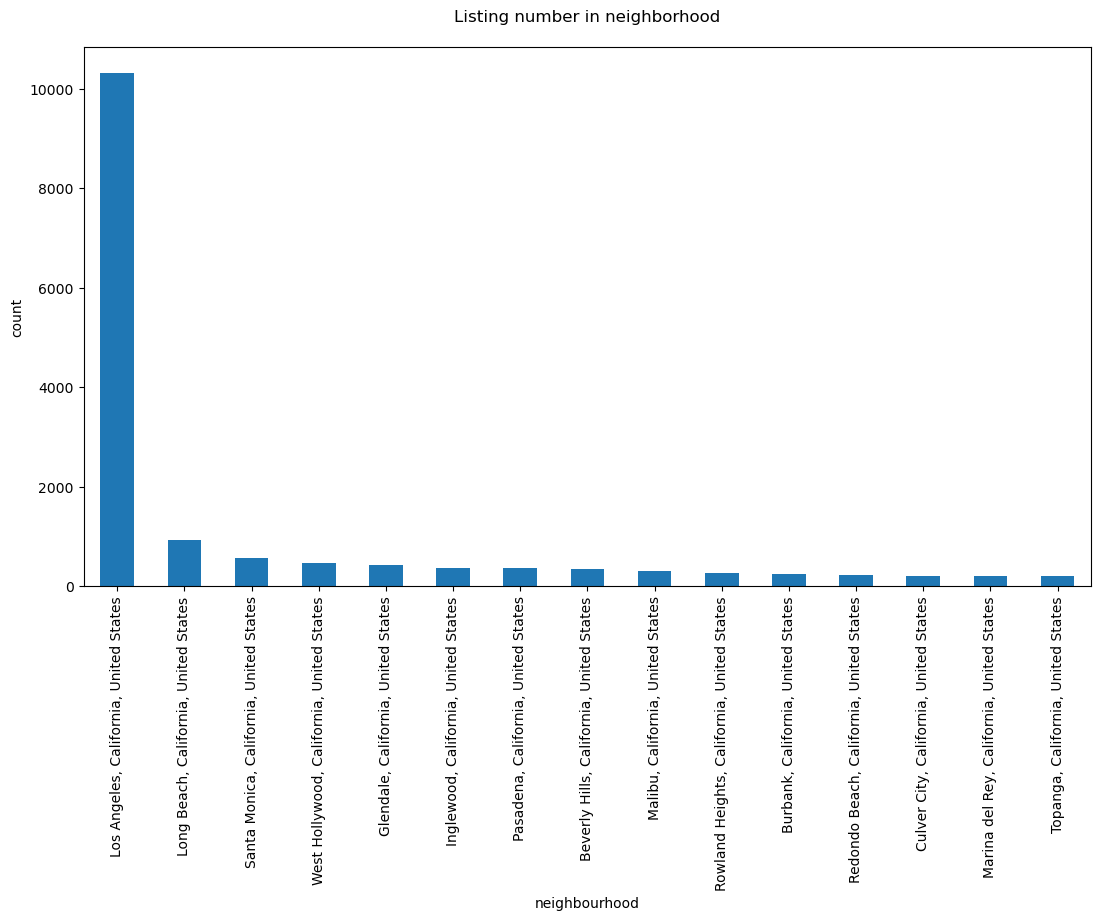

In [6]:
#neighborhood
plt.figure(figsize=(13,7))
plt.title("Listing number in neighborhood\n")
df['neighbourhood'].value_counts().head(15).plot(kind="bar")
plt.xlabel("neighbourhood")
plt.ylabel("count")

#### Figure 2

Text(0, 0.5, 'count')

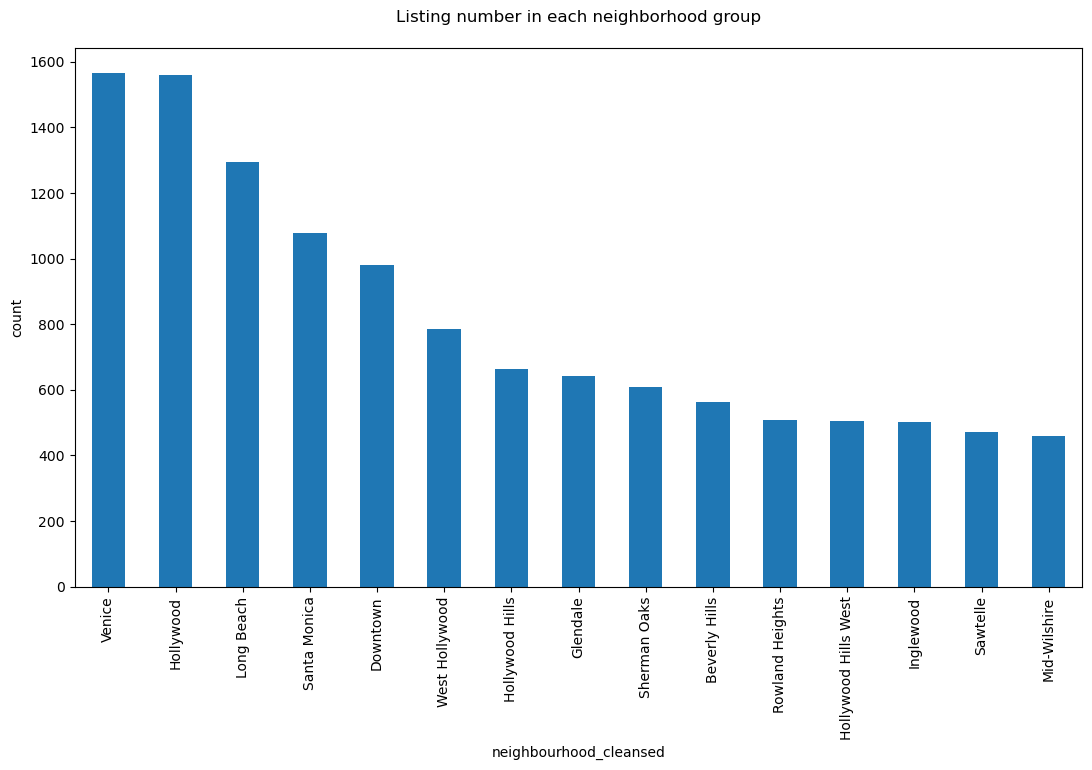

In [7]:
#neighborhood_cleansed
plt.figure(figsize=(13,7))
plt.title("Listing number in each neighborhood group\n")
df['neighbourhood_cleansed'].value_counts().head(15).plot(kind="bar")
plt.xlabel("neighbourhood_cleansed")
plt.ylabel("count")

#### Figure 3

In [8]:
LA_location_mean=df.groupby(["neighbourhood_cleansed"]).mean()["price"]
LA_location_mean=pd.Series(LA_location_mean)

Text(0, 0.5, 'count')

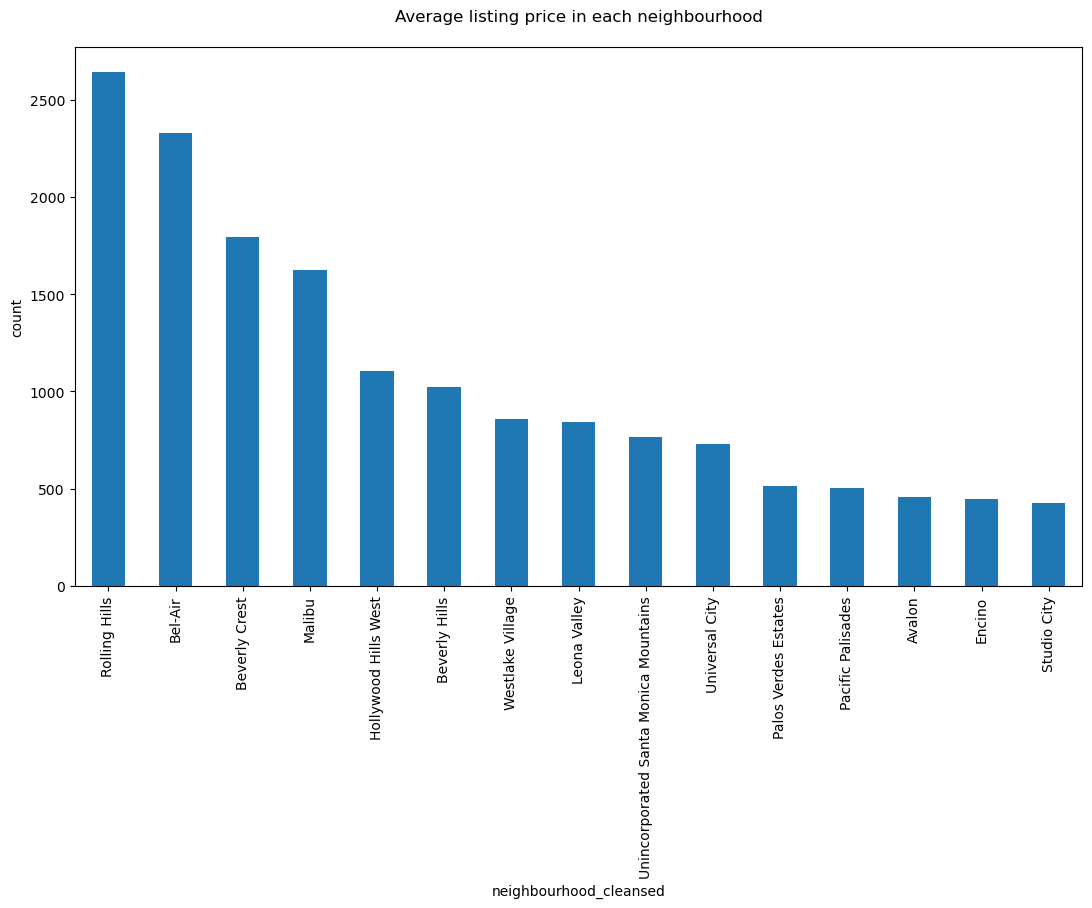

In [9]:
plt.figure(figsize=(13,7))
plt.title("Average listing price in each neighbourhood\n")
LA_location_mean.sort_values(ascending=False).head(15).plot(kind='bar')
plt.xlabel("neighbourhood_cleansed")
plt.ylabel("count")

#### Figure 4

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


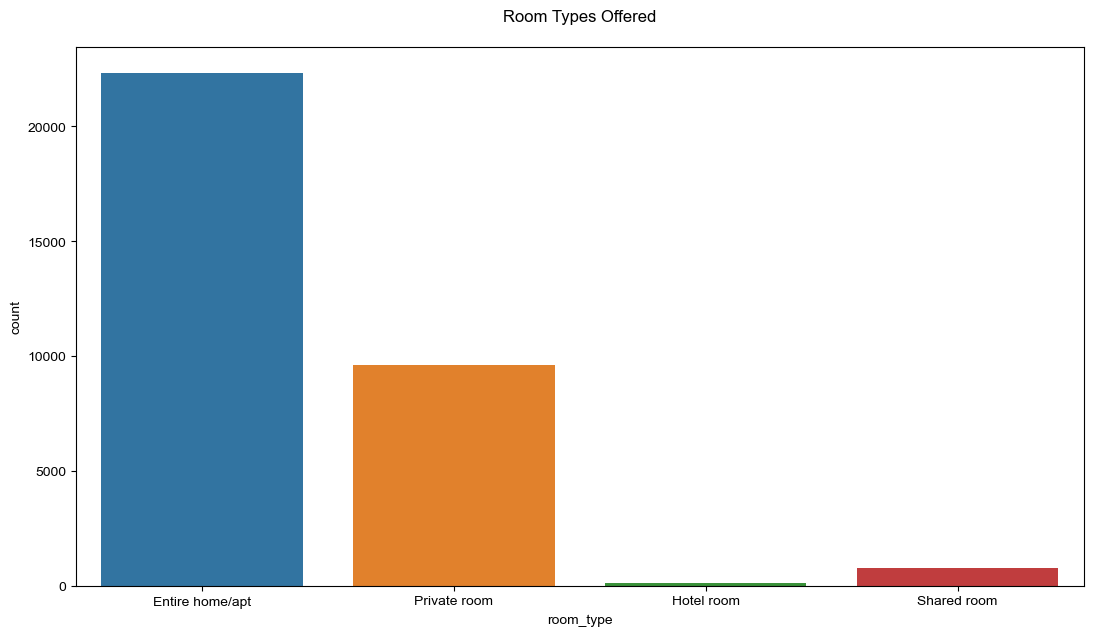

In [10]:
#room_type
plt.figure(figsize=(13,7))
sns.countplot(df.room_type)
sns.set_style("whitegrid")
plt.title("Room Types Offered\n")
plt.show()

### Correlation between selected variables (Heatmaps)

Explanation: 
- Correlation Ranges from -1 to 1 ( 0 = no correlation )
- Color Intensity ( Lighter: higher correlation / Darker: lower correlation )

#### Correlation between bedroom features and price 

In [11]:
select1_df = df[["accommodates", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights"]].copy()

<AxesSubplot:title={'center':'Correlation Between Different Variables\n'}>

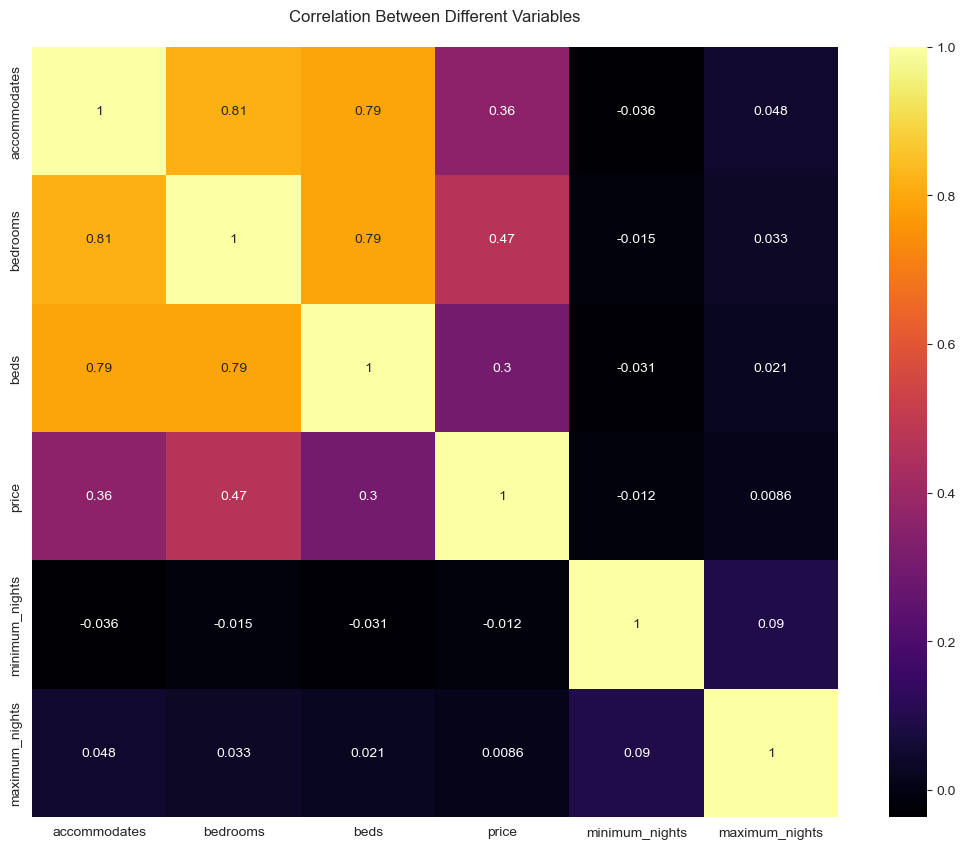

In [12]:
corr = select1_df.corr()
plt.figure(figsize=(13,10))
plt.title("Correlation Between Different Variables\n")
sns.heatmap(corr, xticklabels=corr.columns, yticklabels = corr.columns, annot = True, cmap = "inferno")

#### Correlation between days availability and price

In [13]:
select2_df = df[["availability_30", "price", "availability_60", "availability_90", "availability_365"]].copy()

<AxesSubplot:title={'center':'Correlation Between Different Variables\n'}>

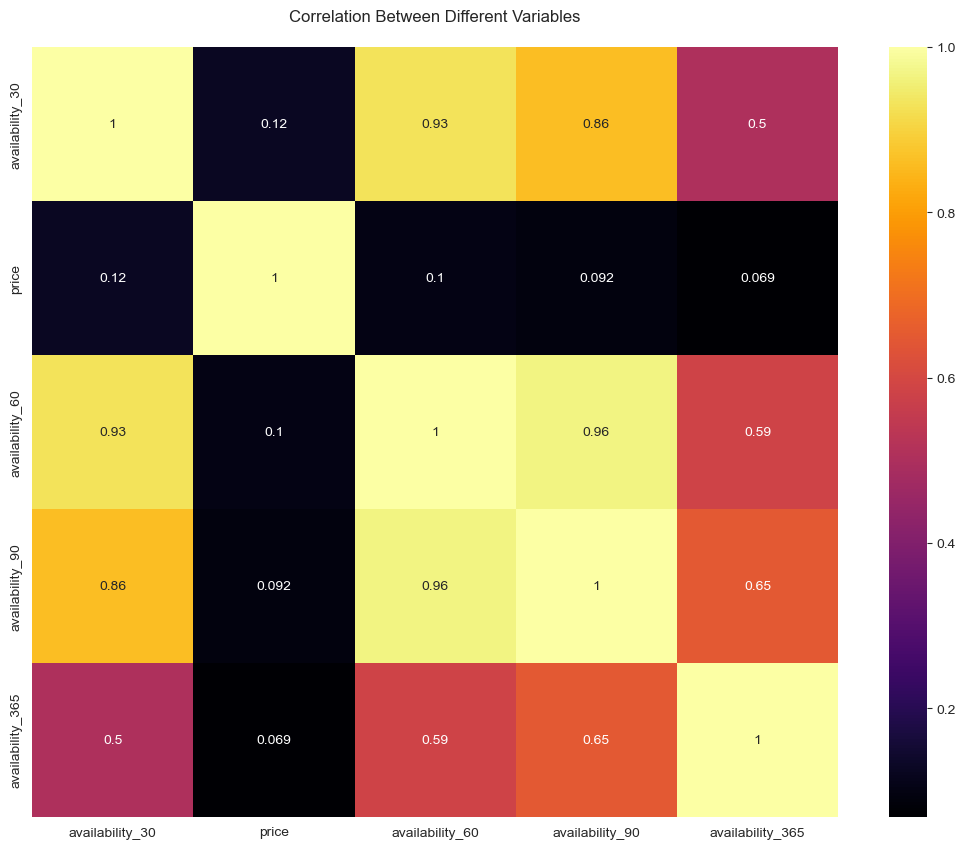

In [14]:
corr = select2_df.corr()
plt.figure(figsize=(13,10))
plt.title("Correlation Between Different Variables\n")
sns.heatmap(corr, xticklabels=corr.columns, yticklabels = corr.columns, annot = True, cmap = "inferno")

#### Correlation between review variables and price

In [15]:
select3_df = df[["number_of_reviews","review_scores_rating", "review_scores_value", "review_scores_checkin", "price", "review_scores_location", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_communication", "reviews_per_month"]].copy()

<AxesSubplot:title={'center':'Correlation Between Different Variables\n'}>

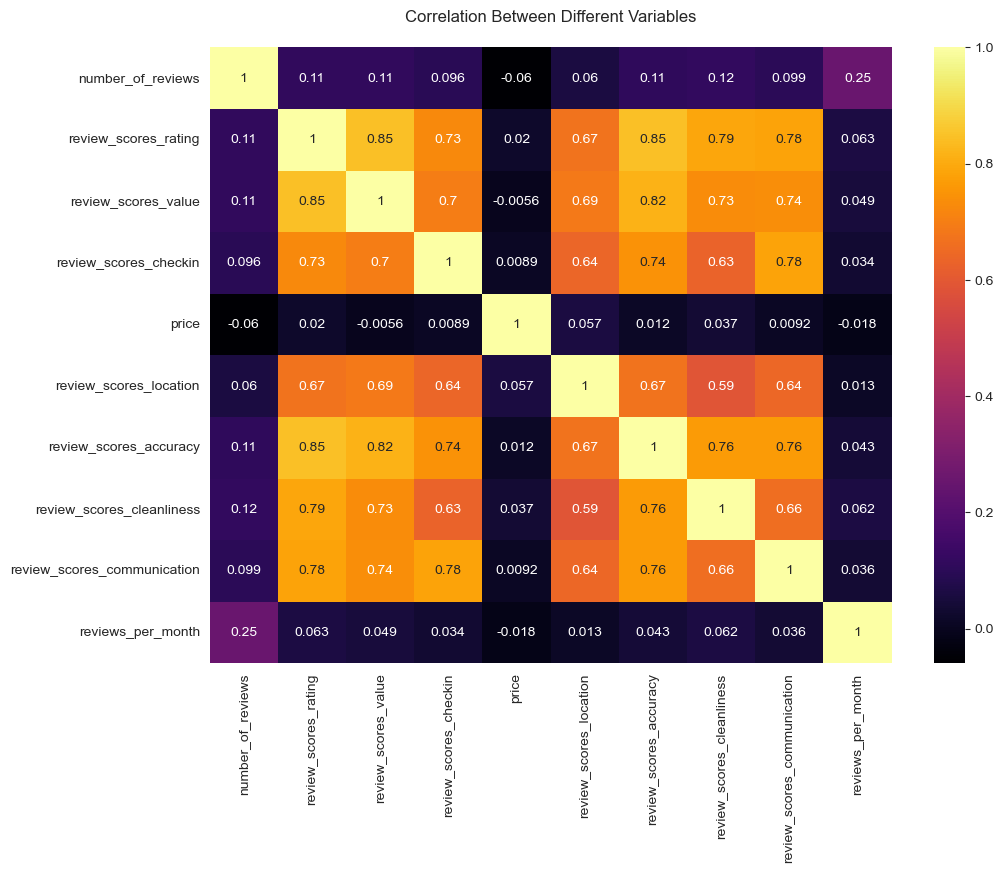

In [16]:
corr = select3_df.corr()
plt.figure(figsize=(11,8))
plt.title("Correlation Between Different Variables\n")
sns.heatmap(corr, xticklabels=corr.columns, yticklabels = corr.columns, annot = True, cmap = "inferno")

### Price Prediction Model

#### OLS Regression Analysis 

In [17]:
df["baths"] = df["bathrooms_text"].str.replace("[^0-9.-]", "", regex = True)
df["baths"] = pd.to_numeric(df["baths"], errors = 'coerce')

df = df.dropna(subset = ['price'])

df.insert(len(df.columns), 'price2', np.log(df.iloc[:, 39] + 0.001))
df = df.dropna(subset = ['price2'])

df["host_is_superhost"] = pd.get_dummies(df['host_is_superhost'])["t"] 

In [18]:
y = df["price2"]
x = df.drop(["price", "price2"], axis = 1)
x = df[["bedrooms", "beds", "accommodates", "host_is_superhost","review_scores_rating", "host_listings_count", "availability_30", "minimum_nights"]]

df = df.reset_index()
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size = 0.7, 
                                                    test_size = 0.3, random_state = 100)

xtrain_const = sm.add_constant(xtrain)
xtest_const = sm.add_constant(xtest)

results = sm.OLS(ytrain, xtrain_const.astype(float), missing = 'drop').fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 price2   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     2045.
Date:                Fri, 11 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:01:45   Log-Likelihood:                -13240.
No. Observations:               14911   AIC:                         2.650e+04
Df Residuals:                   14902   BIC:                         2.657e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.6516 

#### Linear Regression

In [19]:
abnb = pd.read_csv("listings-cleaned.csv")
print(abnb.shape)

(32877, 12)


In [20]:
abnb.dropna()

,neighbourhood,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights
1,"Los Angeles, California, United States",Hollywood,34.096250,-118.346050,Private room,1,1 shared bath,1.0,1.0,$89.00,30,366
2,"Santa Monica, California, United States",Santa Monica,34.004400,-118.480950,Private room,1,1 private bath,1.0,1.0,$167.00,7,28
3,"Bellflower, California, United States",Bellflower,33.874900,-118.115150,Entire home/apt,2,1 bath,1.0,1.0,$50.00,30,730
4,"Los Angeles, California, United States",Hollywood Hills West,34.111600,-118.382230,Entire home/apt,2,1 bath,1.0,2.0,$118.00,31,730
5,"Los Angeles, California, United States",Del Rey,33.987500,-118.432000,Private room,1,1 shared bath,1.0,1.0,$50.00,30,1125
...,...,...,...,...,...,...,...,...,...,...,...,...
32833,"El Monte, California, United States",El Monte,34.076060,-118.013074,Private room,1,1 shared bath,2.0,2.0,$32.00,28,365
32839,"Los Angeles, California, United States",Westlake,34.053211,-118.261446,Entire home/apt,2,1 bath,1.0,1.0,$250.00,31,1125
32846,"Long Beach, California, United States",Long Beach,33.764590,-118.176340,Entire home/apt,6,2 baths,2.0,3.0,$199.00,3,999
32853,"Los Angeles, California, United States",Sherman Oaks,34.153760,-118.438220,Entire home/apt,4,1 bath,1.0,2.0,$125.00,30,1125


In [21]:
abnb = abnb[~abnb.isin([np.nan, np.inf, -np.inf]).any(1)]

In [22]:
# convert "price" from string to float
abnb["price"] = abnb["price"].str.replace('$', '')
abnb["price"] = abnb["price"].str.replace(',', '').astype(float)

# exclude outliers ">$1500"
abnb.drop(abnb[abnb.price > 1500].index, inplace=True)

/var/folders/96/rqbzsn5529g1d_vxq41j85lr0000gn/T/ipykernel_39563/539355711.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  abnb["price"] = abnb["price"].str.replace('$', '')


In [23]:
x = abnb[["bedrooms", 'beds', 'accommodates']]

y = abnb["price"]

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, test_size = 0.3)

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
model = LinearRegression()

In [29]:
model.fit(x_train, y_train)

LinearRegression()

In [30]:
print(model.coef_)

[116.6197945  -15.29129592  17.98142538]


In [31]:
print(model.intercept_)

-27.926321232509252


In [32]:
# e.g. one unit increase in bedrooms will cause a 113 unit increase in price (predicted variable)
pd.DataFrame(model.coef_, x.columns, columns = ['Coeff'])

,Coeff
bedrooms,116.619795
beds,-15.291296
accommodates,17.981425


In [33]:
predictions = model.predict(x_test)

(0.0, 1600.0)

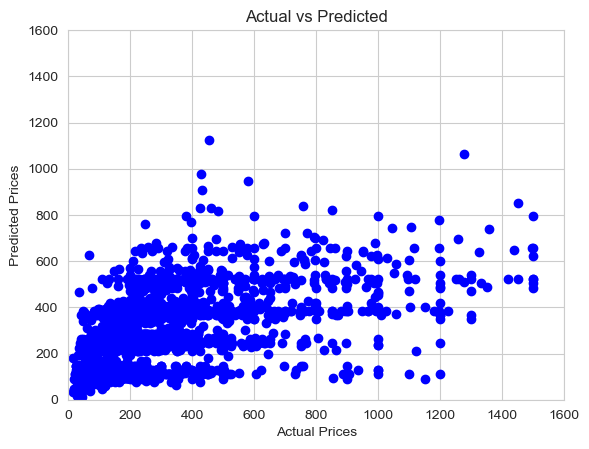

In [34]:
plt.scatter(y_test, predictions, color='b')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted")
plt.xlim([0, 1600])
plt.ylim([0, 1600])

END